In [ ]:
import torch
torch.__version__

In [ ]:
torch.cuda.get_device_name(0)

In [2]:
from super_gradients.training import models
#yolo_nas = models.get('yolo_nas_l',pretrained_weights='coco')

In [ ]:
#device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:

model = models.get(
    model_name='yolo_nas_l',
    checkpoint_path='S:/Jupyter_Notebooks/Object Detection/checkpoints/ckpt_best.pth',
    num_classes=1
)


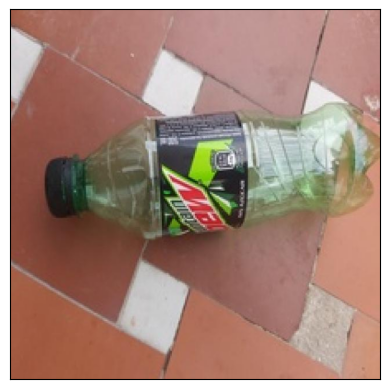

In [1]:
import cv2
import matplotlib.pyplot as plt

im =  cv2.imread("dew.jpg")
img = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

# Plotting the image
def plot_image(img, cmap=None):
    plt.imshow(img, cmap=cmap)
    plt.xticks([])
    plt.yticks([])
    
plot_image(img)
plt.show()

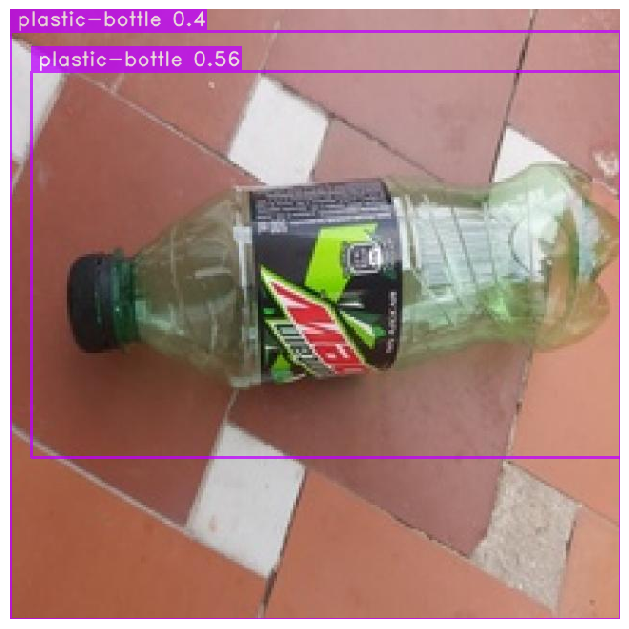

In [4]:
model.predict(img, conf=0.25).show()

In [5]:
import torch 
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
input_vid = "water_bottle.mp4"
output_vid = "output_water_bottle.mp4"
device=0

model.to(device).predict(input_vid).save(output_vid)

Predicting Video: 100%|██████████████████████████████████████████████████████████████| 211/211 [03:35<00:00,  1.02s/it]


In [8]:
#import torch
#from super_gradients.common.object_names import Models
#from super_gradients.training import models

#model = models.get(Models.YOLOX_N, pretrained_weights='coco')

model = model.to("cuda" if torch.cuda.is_available() else "cpu")

model.predict_webcam()

# Custom Model Creating

In [ ]:
#creating custom model

import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

from super_gradients.training import Trainer

CHECKPOINT_DIR = "S:/Jupyter_Notebooks/Object Detection/checkpoints"
trainer = Trainer(experiment_name='Custom_yolo', ckpt_root_dir=CHECKPOINT_DIR)

In [ ]:
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val

In [1]:
dataset_params = {
    'data_dir':'plastic',
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'val/images',
    'val_labels_dir':'val/labels',
    'test_images_dir':'test/images',
    'test_labels_dir':'test/labels',
    'classes': ['plactic']
}

In [ ]:
from IPython.display import clear_output

train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

clear_output()

In [ ]:
train_data.dataset.transforms

In [ ]:
train_data.dataset.dataset_params['transforms'][1]

In [ ]:
train_data.dataset.dataset_params['transforms'][1]['DetectionRandomAffine']['degrees'] = 10.42

In [ ]:
train_data.dataset.plot()

In [2]:
from super_gradients.training import models
model = models.get('yolo_nas_l', 
                   num_classes=len(dataset_params['classes']), 
                   pretrained_weights="coco"
                   )

In [ ]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

train_params = {
    # ENABLING SILENT MODE
    'silent_mode': True,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # ONLY TRAINING FOR 10 EPOCHS FOR THIS EXAMPLE NOTEBOOK
    "max_epochs": 100,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

In [ ]:
import gc
import torch

gc.collect()

torch.cuda.empty_cache()

In [ ]:
trainer.train(model=model, 
              training_params=train_params, 
              train_loader=train_data, 
              valid_loader=val_data)

In [3]:
best_model = models.get('yolo_nas_l',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path='S:/Jupyter_Notebooks/Object Detection/checkpoints/ckpt_best.pth')

In [ ]:
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1,
                                                   top_k_predictions=300,
                                                   num_cls=len(dataset_params['classes']),
                                                   normalize_targets=True,
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                          nms_top_k=1000,
                                                                                                          max_predictions=300,
                                                                                                          nms_threshold=0.7)
                                                  ))

In [ ]:
test_image = 'dew.jpg'
best_model.predict(test_image).show()